# Verdict Transitions (OPT_A → OPT_B)

**Purpose:** Track *individual functions* across two selected optimization
levels to see exactly how each function's alignment changes.

1. **Transition heatmap** — how many functions move from verdict X at OPT_A
   to verdict Y at OPT_B.
2. **Fragility ranking** — bar chart of per-function Δ-overlap, sorted by
   degradation magnitude.

Set `OPT_A` and `OPT_B` in the load cell below to compare any pair of
optimization levels (e.g., O0 → O1, O0 → O3).

**Critical fix:** The old notebook matched functions across opt levels by
`dwarf_function_name`, which silently collapsed static functions with the
same name (35–55% data loss, see Audit.md BUG-1). This notebook uses
`compute_transitions()` which matches on stable source-level identity:
`(test_case, decl_file, decl_line, decl_column, dwarf_function_name_norm)` —
the declaration location from DWARF metadata.

In [2]:
## ── Imports & Style ──────────────────────────────────────────────────────────

from pathlib import Path
import sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, str(Path("../..").resolve()))

from data import (
    load_dataset, enrich_pairs, compute_transitions,
    AlignmentVerdict, OracleVerdict, StableKeyQuality,
)
from data.enums import StableKeyQuality

warnings.filterwarnings("ignore", category=FutureWarning)

OPT_COLORS = {"O0": "#4daf4a", "O1": "#377eb8"}

THESIS_RC = {
    "font.family": "serif", "font.size": 10,
    "axes.titlesize": 12, "axes.labelsize": 10,
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "legend.fontsize": 9, "figure.dpi": 120,
    "savefig.dpi": 300, "savefig.bbox": "tight",
    "figure.figsize": (7, 4.5),
    "axes.spines.top": False, "axes.spines.right": False,
}
plt.rcParams.update(THESIS_RC)
sns.set_context("paper", rc=THESIS_RC)

FIG_DIR = Path("../../figures/oracle_analysis")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(name: str, fig=None):
    fig = fig or plt.gcf()
    for ext in ("pdf", "png"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")
    print(f"  → saved {FIG_DIR / name}.{{pdf,png}}")

print("✓ imports & style ready")

✓ imports & style ready


In [3]:
## ── Load Data & Compute Transitions ─────────────────────────────────────────

SELECTED_TESTS: list[str] | None = None
OPT_LEVELS = ["O0", "O1", "O2", "O3"]   # all levels loaded for flexibility
VARIANT = "debug"

# ── Choose which two levels to compare ───────────────────────────────────────
OPT_A = "O0"   # baseline
OPT_B = "O3"   # comparison target

ds = load_dataset(
    Path("../../docker/local-files/artifacts/synthetic"),
    test_cases=SELECTED_TESTS,
    opt_levels=OPT_LEVELS,
    variant=VARIANT,
)

df_pairs = enrich_pairs(ds.pairs)
tests    = ds.test_cases

# compute_transitions uses stable identity (decl_file, decl_line, decl_column,
# name_norm) to match functions across opt levels.  No name-based collapse.
df_trans = compute_transitions(
    df_pairs, ds.non_targets,
    opt_a=OPT_A, opt_b=OPT_B,
)

n_high = (df_trans["key_quality"] == StableKeyQuality.HIGH.value).sum()
n_medium = (df_trans["key_quality"] == StableKeyQuality.MEDIUM.value).sum()
n_unresolved = (df_trans["key_quality"] == StableKeyQuality.UNRESOLVED.value).sum()
n_dropped = df_trans["dropped"].sum()

print(f"✓ {len(df_trans)} transition rows ({OPT_A} → {OPT_B})")
print(f"  {n_high} HIGH, {n_medium} MEDIUM, {n_unresolved} UNRESOLVED")
print(f"  {n_dropped} dropped (targetable at {OPT_A}, lost at {OPT_B})")

✓ 414 transition rows (O0 → O3)
  364 HIGH, 29 MEDIUM, 21 UNRESOLVED
  83 dropped (targetable at O0, lost at O3)


---
## Plot 1 — Verdict Transition Heatmap

**What it shows:** A matrix where row = verdict at OPT_A, column = verdict at
OPT_B. Each cell count = number of functions that transitioned that way.

**Function used:** `compute_transitions(df_pairs, ds.non_targets, opt_a=OPT_A, opt_b=OPT_B)`

**How it's computed:**

1. For each function, `compute_transitions` finds it at both optimization levels
   using a stable key: `(test_case, decl_file, decl_line, decl_column,
   dwarf_function_name_norm)`. This is the source file + line + column where
   the function is *declared* in the original C code — it doesn't change with
   optimization.
2. Each function gets `verdict_{OPT_A}` and `verdict_{OPT_B}` (one of: MATCH,
   AMBIGUOUS, NO_MATCH, NON_TARGET, or ABSENT if the function doesn't exist
   at that opt).
3. We crosstab these two columns to count transitions.

**Key transitions to watch:**
- MATCH → NON_TARGET = function was inlined away entirely
- MATCH → NO_MATCH = function survives but line mappings degraded below threshold
- Diagonal = stable functions (same verdict at both levels)

  → saved ..\..\figures\oracle_analysis\08_transition_matrix.{pdf,png}


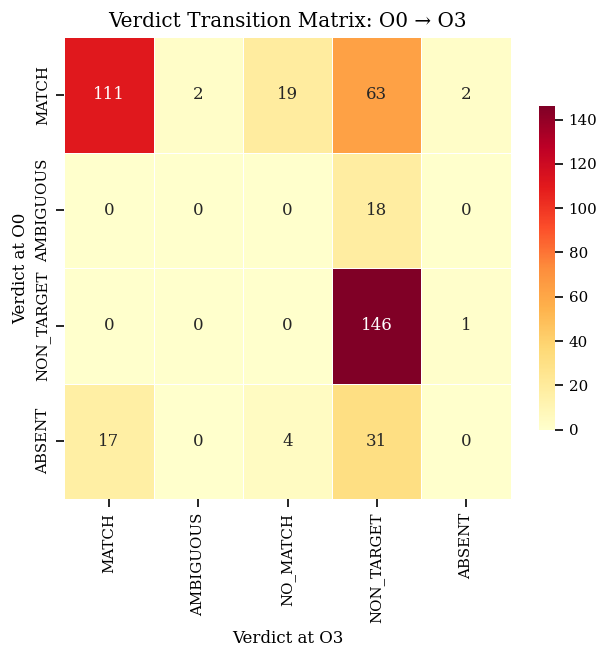

In [4]:
## ── Plot 1: Verdict Transition Heatmap ─────────────────────────────────────────

cats = [
    AlignmentVerdict.MATCH.value,
    AlignmentVerdict.AMBIGUOUS.value,
    AlignmentVerdict.NO_MATCH.value,
    AlignmentVerdict.NON_TARGET.value,
    "ABSENT",
]

matrix = pd.crosstab(
    df_trans[f"verdict_{OPT_A}"],
    df_trans[f"verdict_{OPT_B}"],
).reindex(index=cats, columns=cats, fill_value=0)

# Drop rows/cols that are all zero
matrix = matrix.loc[(matrix.sum(axis=1) > 0), (matrix.sum(axis=0) > 0)]

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt="d", cmap="YlOrRd", ax=ax,
            linewidths=0.5, linecolor="white", cbar_kws={"shrink": 0.7})
ax.set_xlabel(f"Verdict at {OPT_B}")
ax.set_ylabel(f"Verdict at {OPT_A}")
ax.set_title(f"Verdict Transition Matrix: {OPT_A} → {OPT_B}")

save_fig("08_transition_matrix")
plt.show()

---
## Plot 2 — Function Fragility Ranking

**What it shows:** For each function, the change in overlap ratio from OPT_A
to OPT_B, sorted so the most degraded functions appear at the top.

**Function used:** `compute_transitions()` → `delta_overlap` column

**How it's computed:**

```
delta_overlap = overlap_{OPT_B} − overlap_{OPT_A}
```

- Negative delta = the function's overlap got worse under optimization.
- A function present at OPT_A but absent/non-target at OPT_B ("dropped") gets
  `delta_overlap = NaN` — we replace it with `−overlap_{OPT_A}` to represent
  complete loss.

**Color coding:**
- Dark red: Dropped — function existed at OPT_A but was entirely inlined/removed at OPT_B
- Red: Severe degradation (Δ < −0.1)
- Orange: Mild degradation (−0.1 ≤ Δ < −0.01)
- Gray: Stable (|Δ| ≤ 0.01)
- Green: Improved (Δ > 0.01)

**Gap count annotation:** `(gap=N)` shows the OPT_B gap count — a mechanical
explanation for *why* the overlap degraded (foreign DWARF line rows from
inlined code).

In [14]:
## ── Configure test cases for fragility plot ──────────────────────────────────

# Select which test cases to display in the fragility ranking (max 2 for readability)
# Options: None (auto-select first 2), or specify as list: ["simple_functions", "recursion"]
SELECTED_FRAGILITY_TESTS = ["t11_mixed_stress"] # t06_recursion_inline "t13_goto_labels" "t03_header_dominant" "t02_shared_header_macros" "t15_deep_nesting" "t11_mixed_stress"

if SELECTED_FRAGILITY_TESTS is None:
    slope_tests = tests[:2] if len(tests) > 2 else tests
else:
    slope_tests = [t for t in SELECTED_FRAGILITY_TESTS if t in tests][:2] #type: ignore 

print(f"Fragility plot will show: {slope_tests} ({OPT_A} → {OPT_B})")

Fragility plot will show: ['t11_mixed_stress'] (O0 → O3)


  → saved ..\..\figures\oracle_analysis\07_fragility_ranking.{pdf,png}


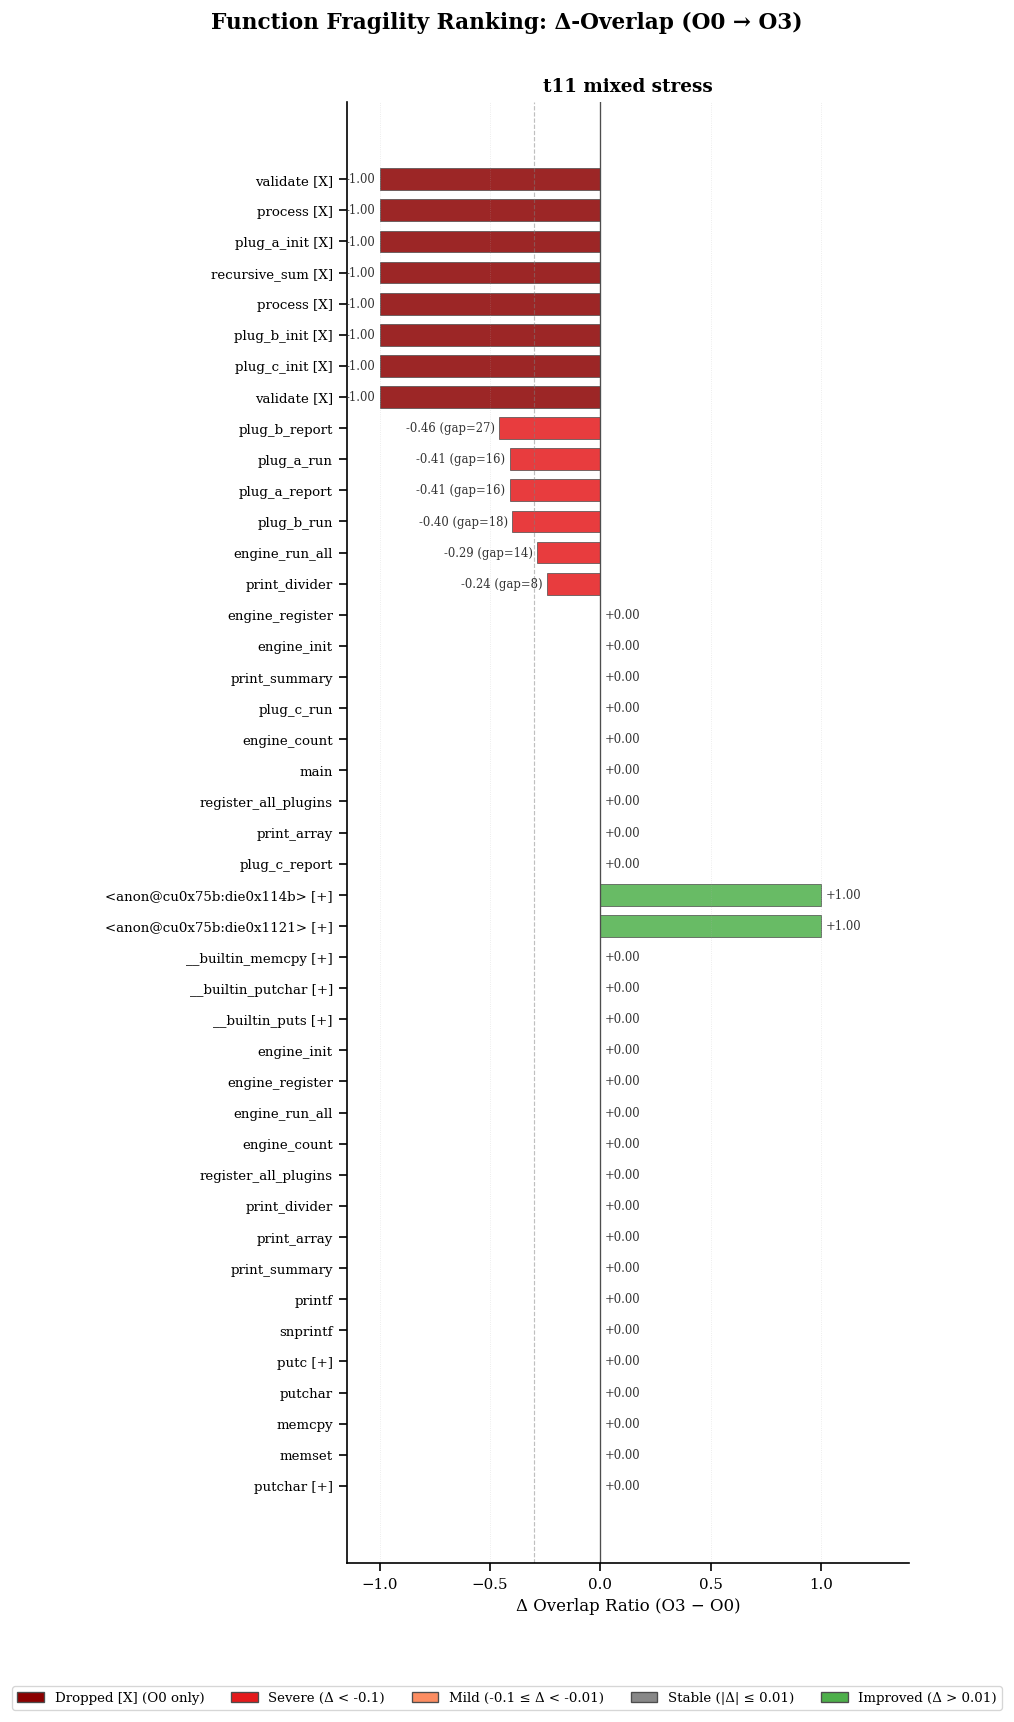

In [15]:
## ── Plot 2: Fragility Ranking (Δ-overlap) ────────────────────────────────────
from matplotlib.patches import Patch

# Use configured test cases (set in cell above)
n_facets = len(slope_tests) #type: ignore
n_cols = min(n_facets, 2)
n_rows = (n_facets + n_cols - 1) // n_cols if n_facets > 0 else 1

# Estimate figure height based on actual function count
max_funcs = max(
    len(df_trans[df_trans["test_case"] == tc])
    for tc in slope_tests
) if slope_tests else 10
fig_height = max(5, min(14, 0.4 * max_funcs * n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(7 * n_cols, fig_height), squeeze=False)
axes_flat = axes.flatten()

for idx, tc in enumerate(slope_tests):
    ax = axes_flat[idx]
    tc_data = df_trans[df_trans["test_case"] == tc].copy()

    if tc_data.empty:
        ax.set_visible(False)
        continue

    # For dropped functions, replace NaN delta with -(OPT_A overlap)
    tc_data["plot_delta"] = tc_data["delta_overlap"]
    dropped_mask = tc_data["dropped"] & tc_data["delta_overlap"].isna()
    tc_data.loc[dropped_mask, "plot_delta"] = -tc_data.loc[dropped_mask, f"overlap_{OPT_A}"]

    # For appeared functions (ABSENT at OPT_A, present at OPT_B),
    # replace NaN delta with +overlap_{OPT_B} (symmetric with dropped)
    appeared_mask = (tc_data[f"verdict_{OPT_A}"] == "ABSENT") & tc_data["delta_overlap"].isna()
    tc_data.loc[appeared_mask, "plot_delta"] = tc_data.loc[appeared_mask, f"overlap_{OPT_B}"]

    tc_data = tc_data.sort_values("plot_delta", ascending=True)

    # Color by degradation severity
    colors = []
    for _, row in tc_data.iterrows():
        if row["dropped"]:
            colors.append("#8B0000")
        elif pd.notna(row["plot_delta"]) and row["plot_delta"] < -0.1:
            colors.append("#e41a1c")
        elif pd.notna(row["plot_delta"]) and row["plot_delta"] < -0.01:
            colors.append("#fc8d62")
        elif pd.notna(row["plot_delta"]) and row["plot_delta"] > 0.01:
            colors.append("#4daf4a")
        else:
            colors.append("#888888")

    y_pos = np.arange(len(tc_data))
    ax.barh(y_pos, tc_data["plot_delta"].fillna(0), color=colors,
            edgecolor="0.3", linewidth=0.5, height=0.7, alpha=0.85)

    # Y-axis labels
    labels = []
    for _, row in tc_data.iterrows():
        name = row.get("dwarf_function_name")
        if pd.isna(name) or name is None:
            name = row.get("dwarf_function_name_norm") or "?"
        name = str(name)
        if row["dropped"]:
            name += " [X]"
        elif row[f"verdict_{OPT_A}"] == "ABSENT":
            name += " [+]"
        labels.append(name)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=8)

    ax.axvline(0, color="0.3", linewidth=0.8)
    ax.axvline(-0.3, color="gray", linestyle="--", linewidth=0.7, alpha=0.5)

    # Δ annotations with gap count
    for i, (_, row) in enumerate(tc_data.iterrows()):
        d = row["plot_delta"] if pd.notna(row["plot_delta"]) else 0
        ha = "left" if d >= 0 else "right"
        offset = 0.02 if d >= 0 else -0.02
        gap_val = row.get(f"gap_{OPT_B}")
        if pd.notna(gap_val) and gap_val > 0:
            label = f"{d:+.2f} (gap={int(gap_val)})"
        else:
            label = f"{d:+.2f}"
        ax.text(d + offset, i, label, fontsize=7, va="center", ha=ha, color="0.2")

    ax.set_xlabel(f"Δ Overlap Ratio ({OPT_B} − {OPT_A})", fontsize=10)

    # Dynamic x-limits: pad beyond data range for annotation text
    dmin = tc_data["plot_delta"].min(skipna=True)
    dmax = tc_data["plot_delta"].max(skipna=True)
    dmin = dmin if pd.notna(dmin) else -1.0
    dmax = dmax if pd.notna(dmax) else 0.0
    ax.set_xlim(min(dmin, -0.1) - 0.15, max(dmax, 0.1) + 0.4)

    ax.set_title(tc.replace("_", " "), fontsize=11, fontweight="bold")
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3, linestyle=':', linewidth=0.5)

for j in range(n_facets, len(axes_flat)):
    axes_flat[j].set_visible(False)

legend_elements = [
    Patch(facecolor="#8B0000", edgecolor="0.3", label=f"Dropped [X] ({OPT_A} only)"),
    Patch(facecolor="#e41a1c", edgecolor="0.3", label="Severe (Δ < -0.1)"),
    Patch(facecolor="#fc8d62", edgecolor="0.3", label="Mild (-0.1 ≤ Δ < -0.01)"),
    Patch(facecolor="#888888", edgecolor="0.3", label="Stable (|Δ| ≤ 0.01)"),
    Patch(facecolor="#4daf4a", edgecolor="0.3", label="Improved (Δ > 0.01)"),
]
fig.legend(handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.02),
           fontsize=8, frameon=True, facecolor="white", edgecolor="0.8", ncol=5)

plt.suptitle(
    f"Function Fragility Ranking: Δ-Overlap ({OPT_A} → {OPT_B})",
    y=0.995, fontsize=13, fontweight="bold",
)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])  # type: ignore
save_fig("07_fragility_ranking")
plt.show()